# Morris and Sobol sensitivity analysis

In [79]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


def lotka_volterra(alpha, beta, delta, gamma, epsilon, eta, zeta, x0, y0, z0):

    # Lotka-Volterra system with 3 dynamic variables
    def lv_equation(t, vars):
        x, y, z = vars
        dxdt = alpha * x - beta * x * y
        dydt = delta * x * y - gamma * y - epsilon * y * z
        dzdt = eta * y * z - zeta * z
        return [dxdt, dydt, dzdt]

    initial_conditions = [x0, y0, z0]

    # Time points where the solution is computed
    t_span = (0, 10)  # Simulate from t=0 to t=100
    t_eval = np.linspace(0, 10, 100)  # 1000 time points for smooth plots

    # Solve the differential equations
    solution = solve_ivp(lv_equation, t_span, initial_conditions, t_eval=t_eval)

    return solution.y

### Morris analysis

In [37]:
from SALib.sample.morris import sample

# Sensitivity analysis settings
problem = {
    "num_vars": 10,
    "names": [
        "alpha",
        "beta",
        "delta",
        "gamma",
        "epsilon",
        "eta",
        "zeta",
        "x0",
        "y0",
        "z0",
    ],
    "bounds": [
        [80.0, 120],
        [10.0, 30.0],
        [0.05, 0.1],
        [0.5, 2.5],
        [2, 6],
        [0.03, 0.09],
        [0.1, 0.5],
        [35, 45],
        [4, 14],
        [1, 9],
    ],
}

# Generate Morris samples
param_values = sample(
    problem, N=100, num_levels=4, optimal_trajectories=10, local_optimization=True
)

In [39]:
from tqdm import tqdm

# Arrays to store the output for each Morris sample
results = np.zeros(
    (param_values.shape[0], 3)
)  # 3 for x, y, z final values at t_span[1]

# Run the model for each set of parameters
for i, params in tqdm(enumerate(param_values), total=param_values.shape[0]):
    # Solve the system of equations using solve_ivp
    sol = lotka_volterra(*params)

    # Store the final values of x, y, z for each parameter set
    results[i, :] = sol[
        :, -1
    ]  # Take the last values in the solution arrays for x, y, z

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:14<00:00,  7.36it/s]


In [51]:
from SALib.analyze.morris import analyze

# Perform the Morris Sensitivity Analysis
analysis_x = analyze(problem, param_values, results[:, 0], num_levels=4)
analysis_y = analyze(problem, param_values, results[:, 1], num_levels=4)
analysis_z = analyze(problem, param_values, results[:, 2], num_levels=4)

avg_sensitivity = (
    analysis_x["mu_star"] + analysis_y["mu_star"] + analysis_z["mu_star"]
) / 3

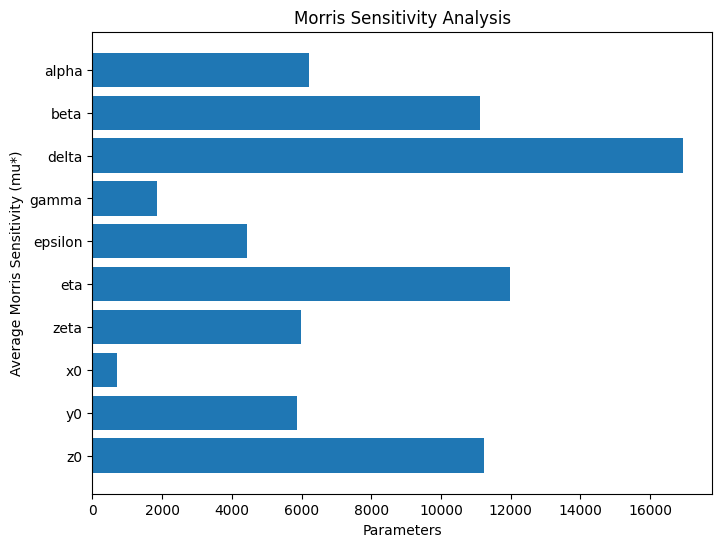

In [65]:
# Plot results for Morris analysis
plt.figure(figsize=(8, 6))
plt.barh(problem["names"][::-1], avg_sensitivity[::-1])
plt.xlabel("Parameters")
plt.ylabel("Average Morris Sensitivity (mu*)")
plt.title("Morris Sensitivity Analysis")
plt.show()

Low sensitivity variables are `gamma`, `epsilon` and `x0`

High sensitivity variables are `beta`, `delta`, `eta` and `z0`

### Sobol Analysis

In [61]:
from SALib.sample import sobol as sobol_sample

# Generate Sobol samples
param_values = sobol_sample.sample(
    problem, 10, calc_second_order=False
)  # Increase this sample size if needed

# Run the model for each set of Sobol sample parameters
results = np.zeros((param_values.shape[0], 3))  # Storing the final values of x, y, z

for i, params in tqdm(enumerate(param_values), total=param_values.shape[0]):
    sol = lotka_volterra(*params)
    results[i, :] = sol[
        :, -1
    ]  # Take the last values in the solution arrays for x, y, z

C:\Users\piotr\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:11<00:00, 10.39it/s]


In [68]:
from SALib.analyze.sobol import analyze

# Sobol analysis for each output variable
sobol_x = analyze(problem, results[:, 0], calc_second_order=False)
sobol_y = analyze(problem, results[:, 1], calc_second_order=False)
sobol_z = analyze(problem, results[:, 2], calc_second_order=False)

# Averaging S1 and ST values across the three outputs
avg_s1 = (np.abs(sobol_x["S1"]) + np.abs(sobol_y["S1"]) + np.abs(sobol_z["S1"])) / 3
avg_st = (np.abs(sobol_x["ST"]) + np.abs(sobol_y["ST"]) + np.abs(sobol_z["ST"])) / 3

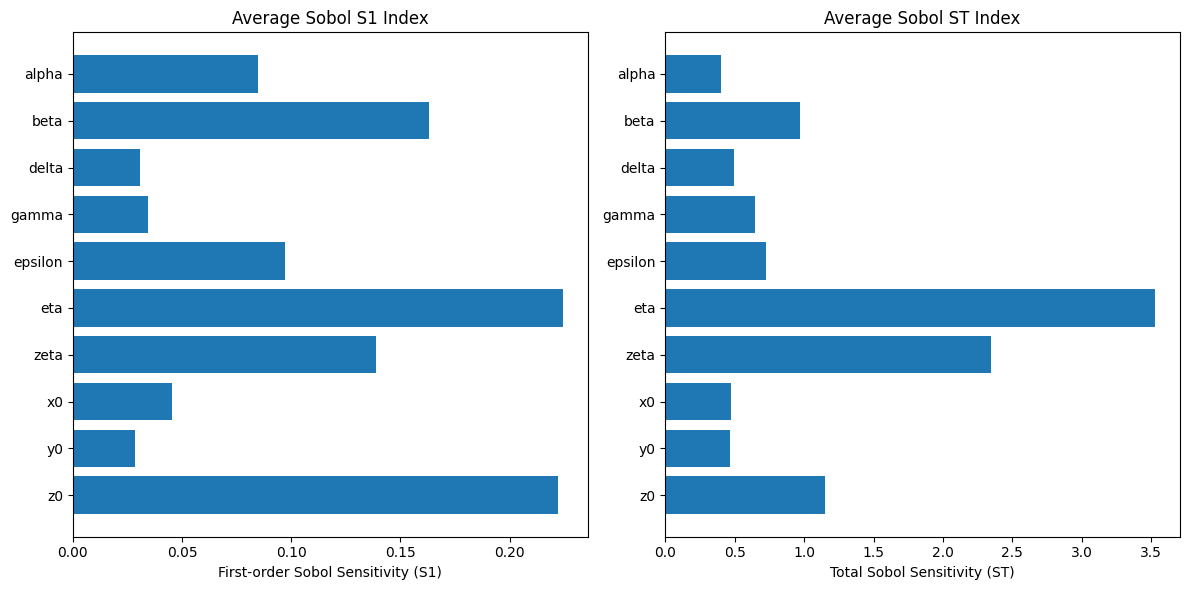

In [69]:
# Plotting the Sobol indices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(problem["names"][::-1], avg_s1[::-1])
plt.xlabel("First-order Sobol Sensitivity (S1) (abs)")
plt.title("Average Sobol S1 Index")

plt.subplot(1, 2, 2)
plt.barh(problem["names"][::-1], avg_st[::-1])
plt.xlabel("Total Sobol Sensitivity (ST) (abs)")
plt.title("Average Sobol ST Index")

plt.tight_layout()
plt.show()

Low sensitivity variables are `alpha`, `delta`, `gamma`, `epsilon`, `x0` and `y0`

High sensitivity variables are `beta`, `delta`, `eta`, `zeta` and `z0`

---

To sum up

For Morris analysis:
- Low sensitivity variables are `gamma`, `epsilon` and `x0`
- High sensitivity variables are `beta`, `delta`, `eta` and `z0`

For Sobol analysis:
- Low sensitivity variables are `alpha`, `delta`, `gamma`, `epsilon`, `x0` and `y0`
- High sensitivity variables are `beta`, `eta`, `zeta` and `z0`

Let's confirm that changes to `gamma`, `epsilon`, `x0` and `y0` don't drastically change the results of the model

In [70]:
param_dict_1 = {"gamma": 1.5, "epsilon": 4, "x0": 40, "y0": 9}
param_dict_2 = {"gamma": 1.4, "epsilon": 5, "x0": 38, "y0": 10}

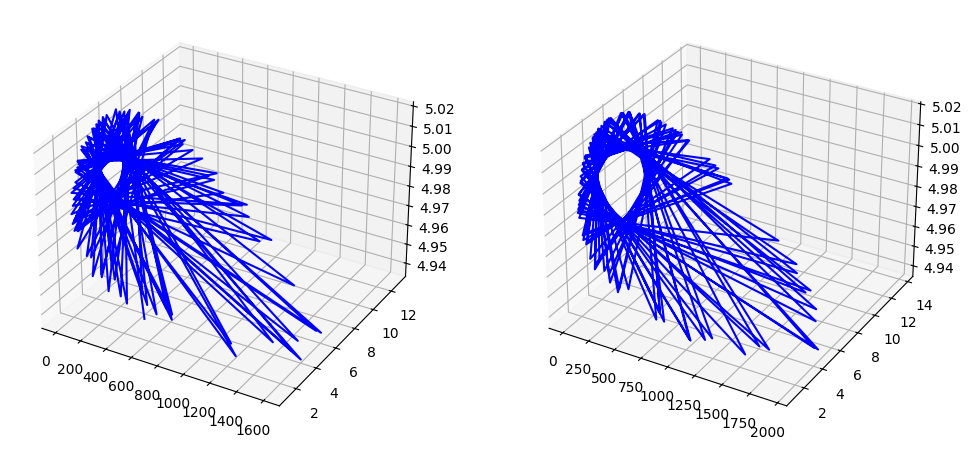

In [80]:
main_dict = {
    "alpha": 100.0,
    "beta": 20.0,
    "delta": 0.075,
    "eta": 0.06,
    "zeta": 0.3,
    "z0": 5,
}

results_1 = lotka_volterra(**main_dict, **param_dict_1)
results_2 = lotka_volterra(**main_dict, **param_dict_2)

# Plot the results in a 3D phase space
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1, projection="3d")
plt.plot(results_1[0], results_1[1], results_1[2], lw=1.5, color="b")

plt.subplot(1, 2, 2, projection="3d")
plt.plot(results_2[0], results_2[1], results_2[2], lw=1.5, color="b")


plt.show()

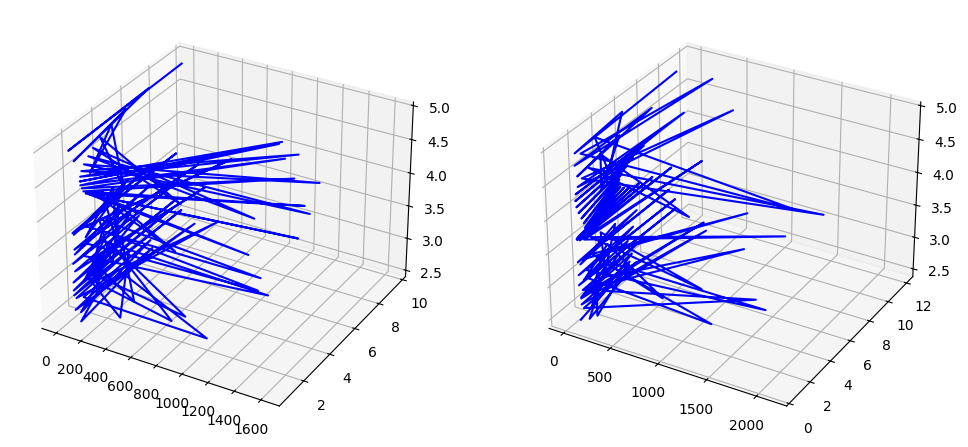

In [82]:
main_dict = {
    "alpha": 95.0,
    "beta": 25.0,
    "delta": 0.075,
    "eta": 0.06,
    "zeta": 0.3,
    "z0": 5,
}

results_1 = lotka_volterra(**main_dict, **param_dict_1)
results_2 = lotka_volterra(**main_dict, **param_dict_2)

# Plot the results in a 3D phase space
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1, projection="3d")
plt.plot(results_1[0], results_1[1], results_1[2], lw=1.5, color="b")

plt.subplot(1, 2, 2, projection="3d")
plt.plot(results_2[0], results_2[1], results_2[2], lw=1.5, color="b")


plt.show()

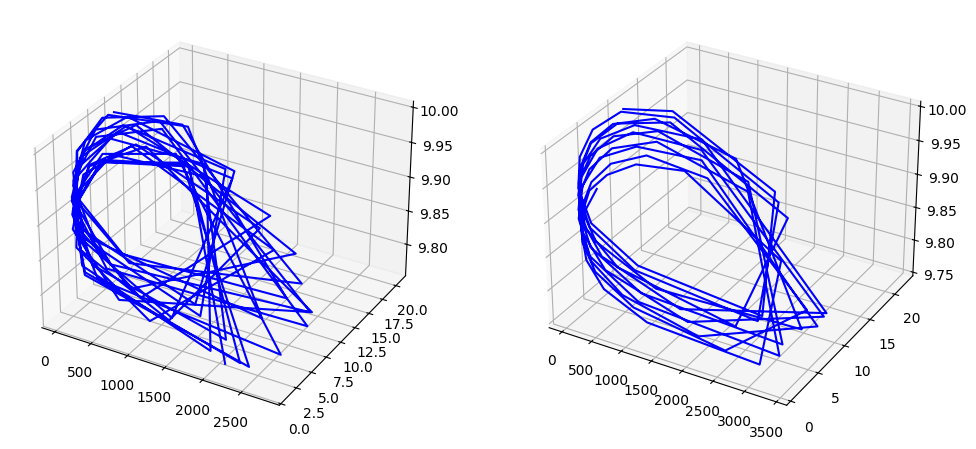

In [92]:
main_dict = {
    "alpha": 100.0,
    "beta": 15.0,
    "delta": 0.07,
    "eta": 0.06,
    "zeta": 0.4,
    "z0": 10,
}

results_1 = lotka_volterra(**main_dict, **param_dict_1)
results_2 = lotka_volterra(**main_dict, **param_dict_2)

# Plot the results in a 3D phase space
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1, projection="3d")
plt.plot(results_1[0], results_1[1], results_1[2], lw=1.5, color="b")

plt.subplot(1, 2, 2, projection="3d")
plt.plot(results_2[0], results_2[1], results_2[2], lw=1.5, color="b")


plt.show()

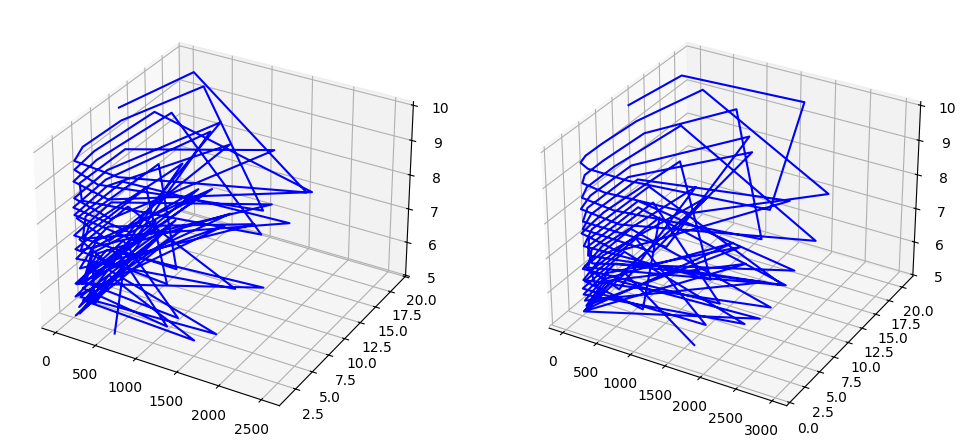

In [94]:
main_dict = {
    "alpha": 100.0,
    "beta": 15.0,
    "delta": 0.07,
    "eta": 0.05,
    "zeta": 0.4,
    "z0": 10,
}

results_1 = lotka_volterra(**main_dict, **param_dict_1)
results_2 = lotka_volterra(**main_dict, **param_dict_2)

# Plot the results in a 3D phase space
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1, projection="3d")
plt.plot(results_1[0], results_1[1], results_1[2], lw=1.5, color="b")

plt.subplot(1, 2, 2, projection="3d")
plt.plot(results_2[0], results_2[1], results_2[2], lw=1.5, color="b")


plt.show()

We can see that the changes resulting from modifying the least sensitive parameters are visible but not as extreme as modifications of sensitive parameters such as `eta` (last 2 plot comparisons)

In conclusion, performing sobol and morris analysis gives us a good insight into how each parameter can affect the results